<a href="https://colab.research.google.com/github/yingzibu/Data_Fraud/blob/main/Benford/test_benfords_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First simulate some data, using one-compartment IV

### Simulation data did not consider outliers. If those exist, not sure which one is more stable.

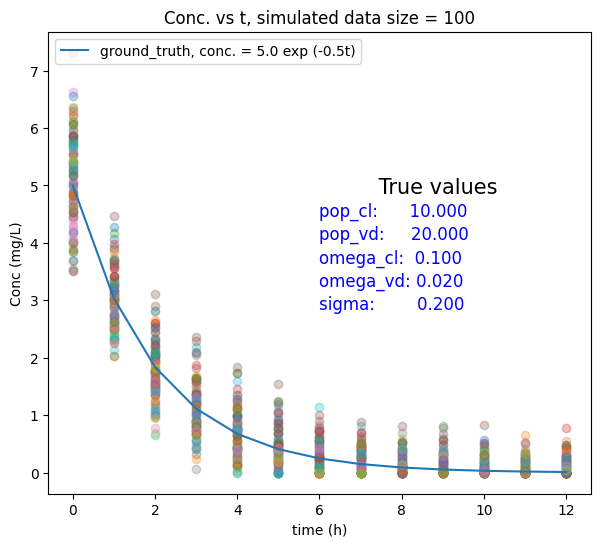

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils import data
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
matplotlib.rcParams['figure.figsize'] = (3.5*2, 6)
import math
np.random.seed(42)
n_patients = 100
n_obs = 13
max_t = n_obs-1
dose = 100
# Population parameters
pop_cl = 10.0  # Population clearance
pop_vd = 20.0  # Population volume

# Variance of random effects (eta)
omg_cl = 0.1  # Variance for clearance
omg_vd = 0.02   # Variance for volume

sigma = 0.2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Simulate data
data = []
min_conc = np.float64(0) # minimal concentration possible is 0
for patient in range(n_patients):
    eta_cl = np.random.normal(0, np.sqrt(omg_cl)) # Random effect of clearance
    eta_vd = np.random.normal(0, np.sqrt(omg_vd))   # Random effect for volume

    for t in range(n_obs):
        time = t  # Time in hours
        # Simple PK model: C(t) = Dose / V * e^(-Cl/V * t)
        ind_v = pop_vd * np.exp(eta_vd)
        ind_cl = pop_cl * np.exp(eta_cl)
        concentration = (dose / ind_v) * np.exp(-ind_cl / ind_v * time)
        # print(concentration)
        # print(type(concentration))
        # break

        # Add some observation error
        concentration += np.random.normal(0, sigma)  # Adding Gaussian noise

        # the min concentration should be 0
        if concentration < min_conc: concentration = min_conc

        data.append([patient, time, concentration])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['patient', 'time', 'concentration'])
for patient in df['patient'].unique():
    patient_data = df[df['patient'] == patient]
    if n_patients <=20:
        plt.scatter(patient_data['time'], patient_data['concentration'],
                label=f'Patient {patient}', alpha=0.7)
    else: plt.scatter(patient_data['time'], patient_data['concentration'], alpha=0.3)

true_conc = [dose / pop_vd * np.exp(-pop_cl / pop_vd * t) for t in range(n_obs)]
plt.plot(range(n_obs), true_conc,
         label=f'ground_truth, conc. = {dose/pop_vd} exp (-{pop_cl/pop_vd}t)')

plt.annotate(f'         True values ',
            xy=(0.5, 0.65), xycoords='axes fraction', fontsize=15, color='black')

plt.annotate(f'pop_cl:      {pop_cl:.3f}',
            xy=(0.5, 0.6), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'pop_vd:     {pop_vd:.3f}',
            xy=(0.5, 0.55), xycoords='axes fraction', fontsize=12, color='blue')

plt.annotate(f'omega_cl:  {omg_cl:.3f}',
            xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'omega_vd: {omg_vd:.3f}',
            xy=(0.5, 0.45), xycoords='axes fraction', fontsize=12, color='blue')

plt.annotate(f'sigma:        {sigma:.3f}',
            xy=(0.5, 0.4), xycoords='axes fraction', fontsize=12, color='blue')
plt.legend(loc=2)
plt.xlabel('time (h)'); plt.ylabel('Conc (mg/L)')
plt.title(f'Conc. vs t, simulated data size = {n_patients}')
plt.show(); plt.close()


# Benford's law

Code reference: https://github.com/milcent/benford_py/tree/master

\begin{align}
P(D_1 = d_1, D_2 = d_2, \cdots, D_k = D_k) &= \log_{10} (1 + \frac{1}{d_1 d_2 \cdots d_k}) \\
P(D_k = d_k) & = \sum_{d_1=1}^{9} \cdots \sum_{d_{k-1} =0}^9 \log_{10} (1 + \frac{1}{d_1 d_2 \cdots d_k})
\end{align}

In [5]:
def first_n_digits(num, n):
    if num <= 0: return 'NA'
    num = abs(num)
    num_list = str(f'{num:.20f}').split('.')
    assert len(num_list) == 2
    num_str = num_list[0] + num_list[1]
    num_str = str(f'{float(num_str):.1f}')
    # print(num_str)

    if n >= len(num_str):
        # return num
        print('digits exceed length of num'); return

    try: return int(num_str[:n])
    except: print(num)


def the_nth_digit(num, n):
    n_here = first_n_digits(num, n)
    return int(str(n_here)[-1])

a = 0.000002412830
first_n_digits(a, 3), the_nth_digit(a, 3)

(241, 1)

In [9]:
digit_df = pd.DataFrame()
digit_df['concentration'] = df['concentration'][df['concentration']>0]
for digit_num in range(1, 4):

    digit_list = []
    for i in digit_df['concentration']:
        digit_list.append(first_n_digits(i, digit_num))
    digit_df[f'digit_{digit_num}'] = digit_list
digit_df = digit_df.reset_index(drop=True)
digit_df

,concentration,digit_1,digit_2,digit_3
0,5.228267,5,52,522
1,3.112396,3,31,311
2,1.499375,1,14,149
3,0.804644,8,80,804
4,0.784734,7,78,784
...,...,...,...,...
1060,0.409825,4,40,409
1061,0.416089,4,41,416
1062,0.243341,2,24,243
1063,0.205546,2,20,205


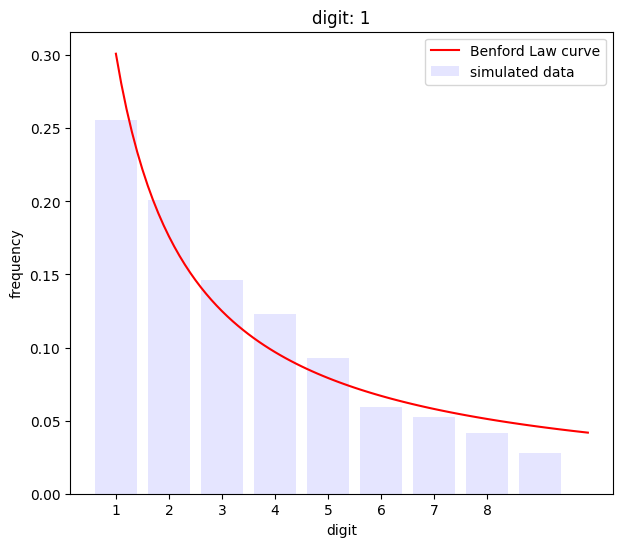

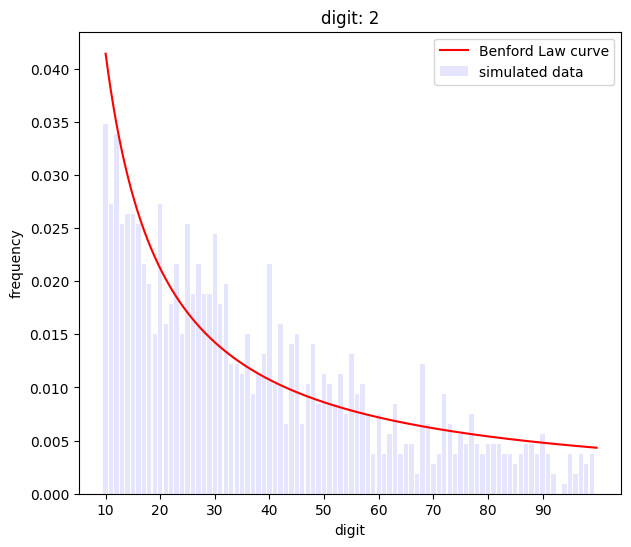

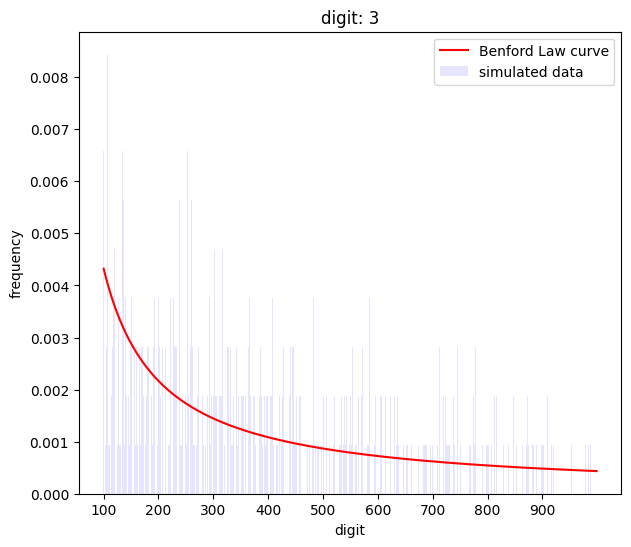

In [13]:
for digit_num in range(1,4):
    data_here = digit_df[f'digit_{digit_num}']
    a = data_here.value_counts(ascending=False)
    total_num = len(digit_df)
    cats = []
    freq = []
    for i,j in a.items():
        # print(i,j/total_num)
        cats.append(i); freq.append(j/total_num)
    max_digit = data_here.max()
    min_digit = data_here.min()

    plt.bar(cats, freq, color='blue', alpha=0.1, label='simulated data')
    x = np.arange(min_digit, max_digit+1, 0.1)
    y = [math.log10(1+1/i) for i in x]
    plt.plot(x, y, color='red', label='Benford Law curve')


    # x = np.arange(min_digit, max_digit+1, 1)
    # y = [math.log10(1+1/i) for i in x]
    # plt.plot(x, y, '*', color='red')

    plt.xlabel('digit'); plt.ylabel('frequency')
    plt.title(f'digit: {digit_num}')

    number_of_steps = 10**(digit_num-1)
    l = np.arange(min_digit, max_digit, number_of_steps)
    plt.xticks(l)

    # plt.(xticks=l, xtickla?bels=l)
    # plt.xticks(cats)
    plt.legend(); plt.show(); plt.close()



In [12]:
single_df = pd.DataFrame()
single_df['concentration'] = df['concentration'][df['concentration']>0]
for digit_num in range(1, 4):

    digit_list = []
    for i in single_df['concentration']:
        digit_list.append(the_nth_digit(i, digit_num))
    single_df[f'digit_{digit_num}'] = digit_list
single_df = single_df.reset_index(drop=True)
single_df

,concentration,digit_1,digit_2,digit_3
0,5.228267,5,2,2
1,3.112396,3,1,1
2,1.499375,1,4,9
3,0.804644,8,0,4
4,0.784734,7,8,4
...,...,...,...,...
1060,0.409825,4,0,9
1061,0.416089,4,1,6
1062,0.243341,2,4,3
1063,0.205546,2,0,5


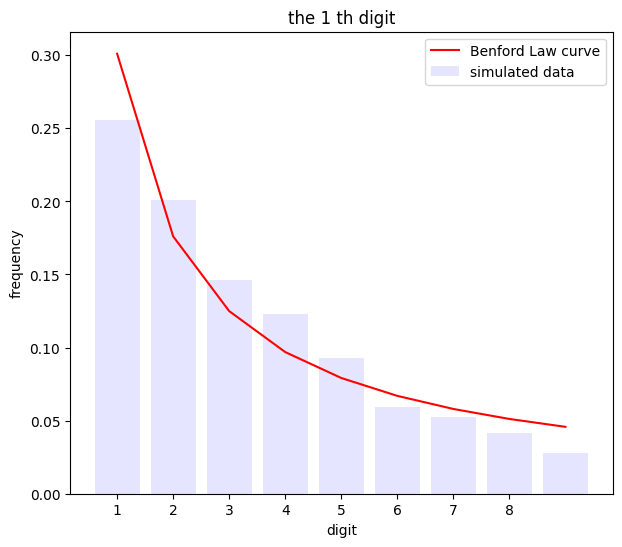

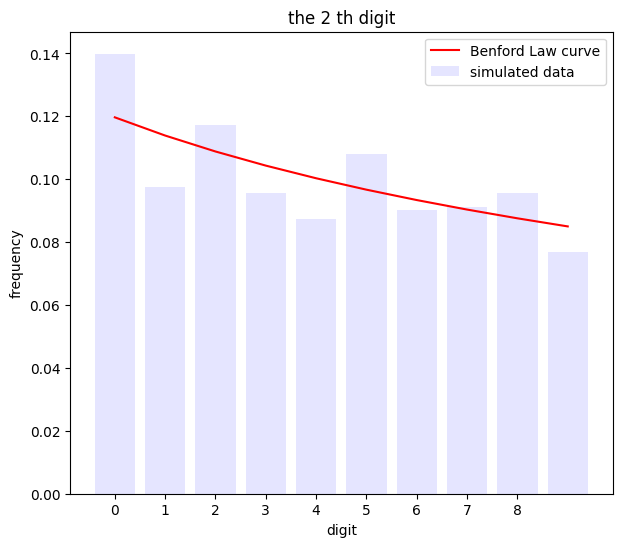

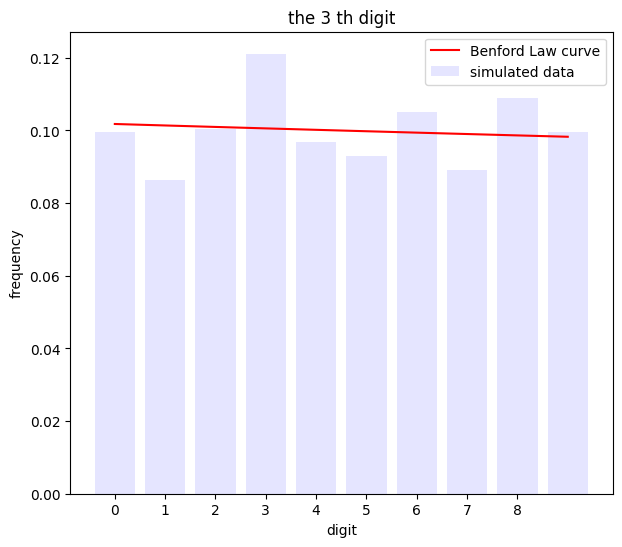

In [16]:
for digit_num in range(1,4):
    data_here = single_df[f'digit_{digit_num}']
    a = data_here.value_counts(ascending=False)
    total_num = len(single_df)
    cats = []
    freq = []
    for i,j in a.items():
        # print(i,j/total_num)
        cats.append(i); freq.append(j/total_num)
    max_digit = data_here.max()
    min_digit = data_here.min()

    plt.bar(cats, freq, color='blue', alpha=0.1, label='simulated data')
    x = np.arange(min_digit, max_digit+1)
    if digit_num == 1:
        y = [math.log10(1+1/i) for i in x]
    elif digit_num == 2:
        y = []
        for i in x:
            y_here = 0
            for d1 in range(1,10):
                y_temp = math.log10(1 + 1/ (d1*10 + i))
                y_here += y_temp
            y.append(y_here)

    elif digit_num == 3:
        y = []
        for i in x:
            y_here = 0
            for d1 in range(1,10):
                for d2 in range(0,10):
                    y_temp = math.log10(1 + 1/ (d1*100 + d2*10 + i))
                    y_here += y_temp
            y.append(y_here)
    plt.plot(x, y, color='red', label='Benford Law curve')


    # x = np.arange(min_digit, max_digit+1, 1)
    # y = [math.log10(1+1/i) for i in x]
    # plt.plot(x, y, '*', color='red')

    plt.xlabel('digit'); plt.ylabel('frequency')
    plt.title(f'the {digit_num} th digit')

    # number_of_steps = 10**(digit_num-1)
    l = np.arange(min_digit, max_digit, 1)
    plt.xticks(l)

    # plt.(xticks=l, xtickla?bels=l)
    # plt.xticks(cats)
    plt.legend(); plt.show(); plt.close()

